In [24]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# use extend to personalize the stop_word set
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])



%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

### load the text

In [32]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df.head(2)

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware


In [33]:
df['target_names'].value_counts()

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
sci.med                     594
rec.autos                   594
sci.space                   593
comp.windows.x              593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: target_names, dtype: int64

In [34]:
df=df.loc[df.target_names.isin(['rec.autos','sci.space','sci.med','sci.electronics']),:]

In [35]:
df['target_names'].value_counts()

sci.med            594
rec.autos          594
sci.space          593
sci.electronics    591
Name: target_names, dtype: int64

## preprocess the text

In [43]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        
        yield(sent)  

data_words = list(sent_to_words(data))

print(data_words[:1])
        


['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL ---- brought to you by your neighborhood Lerxst ---- ']


In [44]:
def preprocess(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(preprocess(data))

print(data_words[:1])


[['from', 'lerxst', 'wam', 'umd', 'edu', 'where', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]

In [45]:
# combine or divide the funcation does not seems to have big difference
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


## build n-grams models 

form the bigram and trigrams using the Phrases model. 

Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs, because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for

In [51]:
from gensim.models.phrases import Phrases, Phraser
bigram=Phrases(data_words,min_count=5,threshold=100)
trigram = Phrases(bigram[data_words], threshold=100) 

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])



['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac', 'wam', 'umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports_car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [52]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [59]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


In [62]:

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['where', 'thing', 'car', 'nntp_poste', 'host', 'rac', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [63]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 4), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)]]


gensim will create a unique id for each word
corpus is  (word_id，word_frequency)

In [64]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 4),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('rac', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

##  Build LDA model

In [65]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)



#chunksize# is the size for each training chunk
#update# the paremeter after each run
#the model# is ready after 100 training

In [66]:
print(lda_model.print_topics())

[(0, '0.087*"oil" + 0.068*"distribution_usa" + 0.056*"fail" + 0.047*"ring" + 0.037*"anywhere" + 0.024*"valve" + 0.022*"specify" + 0.022*"tight" + 0.020*"leak" + 0.020*"observe"'), (1, '0.108*"market" + 0.053*"km" + 0.029*"deliver" + 0.024*"laser" + 0.019*"netter" + 0.014*"effectiveness" + 0.012*"massive" + 0.010*"turbine" + 0.009*"partially" + 0.007*"guilty"'), (2, '0.033*"patient" + 0.030*"food" + 0.026*"pain" + 0.024*"doctor" + 0.023*"cause" + 0.022*"disease" + 0.020*"eat" + 0.018*"msg" + 0.017*"treatment" + 0.016*"child"'), (3, '0.029*"have" + 0.027*"use" + 0.026*"wire" + 0.024*"power" + 0.019*"current" + 0.015*"light" + 0.014*"low" + 0.013*"lead" + 0.013*"circuit" + 0.013*"input"'), (4, '0.066*"practice" + 0.049*"lab" + 0.046*"card" + 0.045*"radar" + 0.027*"amplifier" + 0.025*"reading" + 0.023*"measurement" + 0.016*"improvement" + 0.016*"positive" + 0.015*"accuracy"'), (5, '0.153*"car" + 0.038*"drive" + 0.029*"speed" + 0.025*"buy" + 0.021*"driver" + 0.017*"fast" + 0.017*"model" + 0

## put the topic word into dataframe

In [67]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [69]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.4350,"line, write, article, be, work, time, look, th...","[where, thing, car, nntp_poste, host, rac, par..."
1,1,14.0,0.6466,"line, write, article, be, work, time, look, th...","[distribution, article, write, clear, caution,..."
2,2,14.0,0.5135,"line, write, article, be, work, time, look, th...","[tumor, treatment, thank, line, people, respon..."
3,3,15.0,0.4721,"system, address, vehicle, design, application,...","[david_mckissock, space, organization, center,..."
4,4,14.0,0.3747,"line, write, article, be, work, time, look, th...","[insurance, rate, performance, car, line, rece..."
5,5,14.0,0.3282,"line, write, article, be, work, time, look, th...","[seek, material, lab, line, able, voltage, sig..."
6,6,6.0,0.5396,"ground, hot, connect, water, tube, heat, panel...","[organization, guest, line, write, date, write..."
7,7,14.0,0.4050,"line, write, article, be, work, time, look, th...","[car, saftey, important, line, host, write, sa..."
8,8,14.0,0.5038,"line, write, article, be, work, time, look, th...","[network, line, son, usual, teenage, spotty, g..."
9,9,14.0,0.3725,"line, write, article, be, work, time, look, th...","[line, distribution_usa, host, ca, possible, i..."


In [71]:
df_dominant_topic.shape


(2372, 5)

In [72]:
df.shape

(2372, 3)

abtract the topic and assign each row to a topic

In [76]:
df_dominant_topic['Dominant_Topic'].value_counts()

14.0    2229
8.0       63
3.0       28
2.0       13
7.0        9
6.0        9
15.0       8
9.0        6
5.0        3
13.0       2
16.0       1
0.0        1
Name: Dominant_Topic, dtype: int64

In [85]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=50,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [86]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [87]:
df_dominant_topic['Dominant_Topic'].value_counts()

3.0    1050
2.0     788
0.0     385
1.0     149
Name: Dominant_Topic, dtype: int64

set the model number to 4, the lda model didn't get close to the 4
category I put in

In [84]:
df['target_names'].value_counts()

sci.med            594
rec.autos          594
sci.space          593
sci.electronics    591
Name: target_names, dtype: int64

## put the most common sentence into the dataframe

In [74]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.3841,"oil, distribution_usa, fail, ring, anywhere, valve, specify, tight, leak, observe","[distribution_usa, article, write, change, suitable, bit, turn, succeed, tighten, tight, safe, o..."
1,2.0,0.4562,"patient, food, pain, doctor, cause, disease, eat, msg, treatment, child","[ron_roth, hypoglycemia, gate, line, write, tell, bloodcount, diagnose, hypoglycemic, dangerous,..."
2,3.0,0.6569,"have, use, wire, power, current, light, low, lead, circuit, input","[organization, line, try, build, circuit, detect, video, blank, screen, monitor, output, graphic..."
3,5.0,0.3810,"car, drive, speed, buy, driver, fast, model, saturn, instal, battery","[bigot, host, line, prefer, manual, automatic, believe, automatic, manufacture, people, physical..."
4,6.0,0.5396,"ground, hot, connect, water, tube, heat, panel, equipment, device, protection","[organization, guest, line, write, date, write, really, post, question, figure, board, appropria..."
5,7.0,0.4178,"information, program, available, mail, send, post, chip, datum, technology, list","[weekly, reminder, frequently_asked, question, list, line, expire, notice, post, weekly, space, ..."
6,8.0,0.6975,"year, high, increase, age, less, group, show, report, result, case","[line, live, thing, maintain, small, electric, field, enhance, certain, chemical, reaction, prom..."
7,9.0,0.3621,"space, launch, orbit, mission, satellite, earth, shuttle, lunar, spacecraft, moon","[space, faq, upcome, line, expire, keywords_frequently, asked_questions, archive_name, space, da..."
8,13.0,0.3511,"science, software, process, unit, scientific, factor, level, cycle, development, commercial","[level, reply, nntp_posting, host, dept, line, accord, software, engineering, professor, actuall..."
9,14.0,0.8397,"line, write, article, be, work, time, look, thing, host, much","[read, ok, senegal, write, write, be, go, issue, carry, weapon, ask, think, seriously, shoot, ki..."


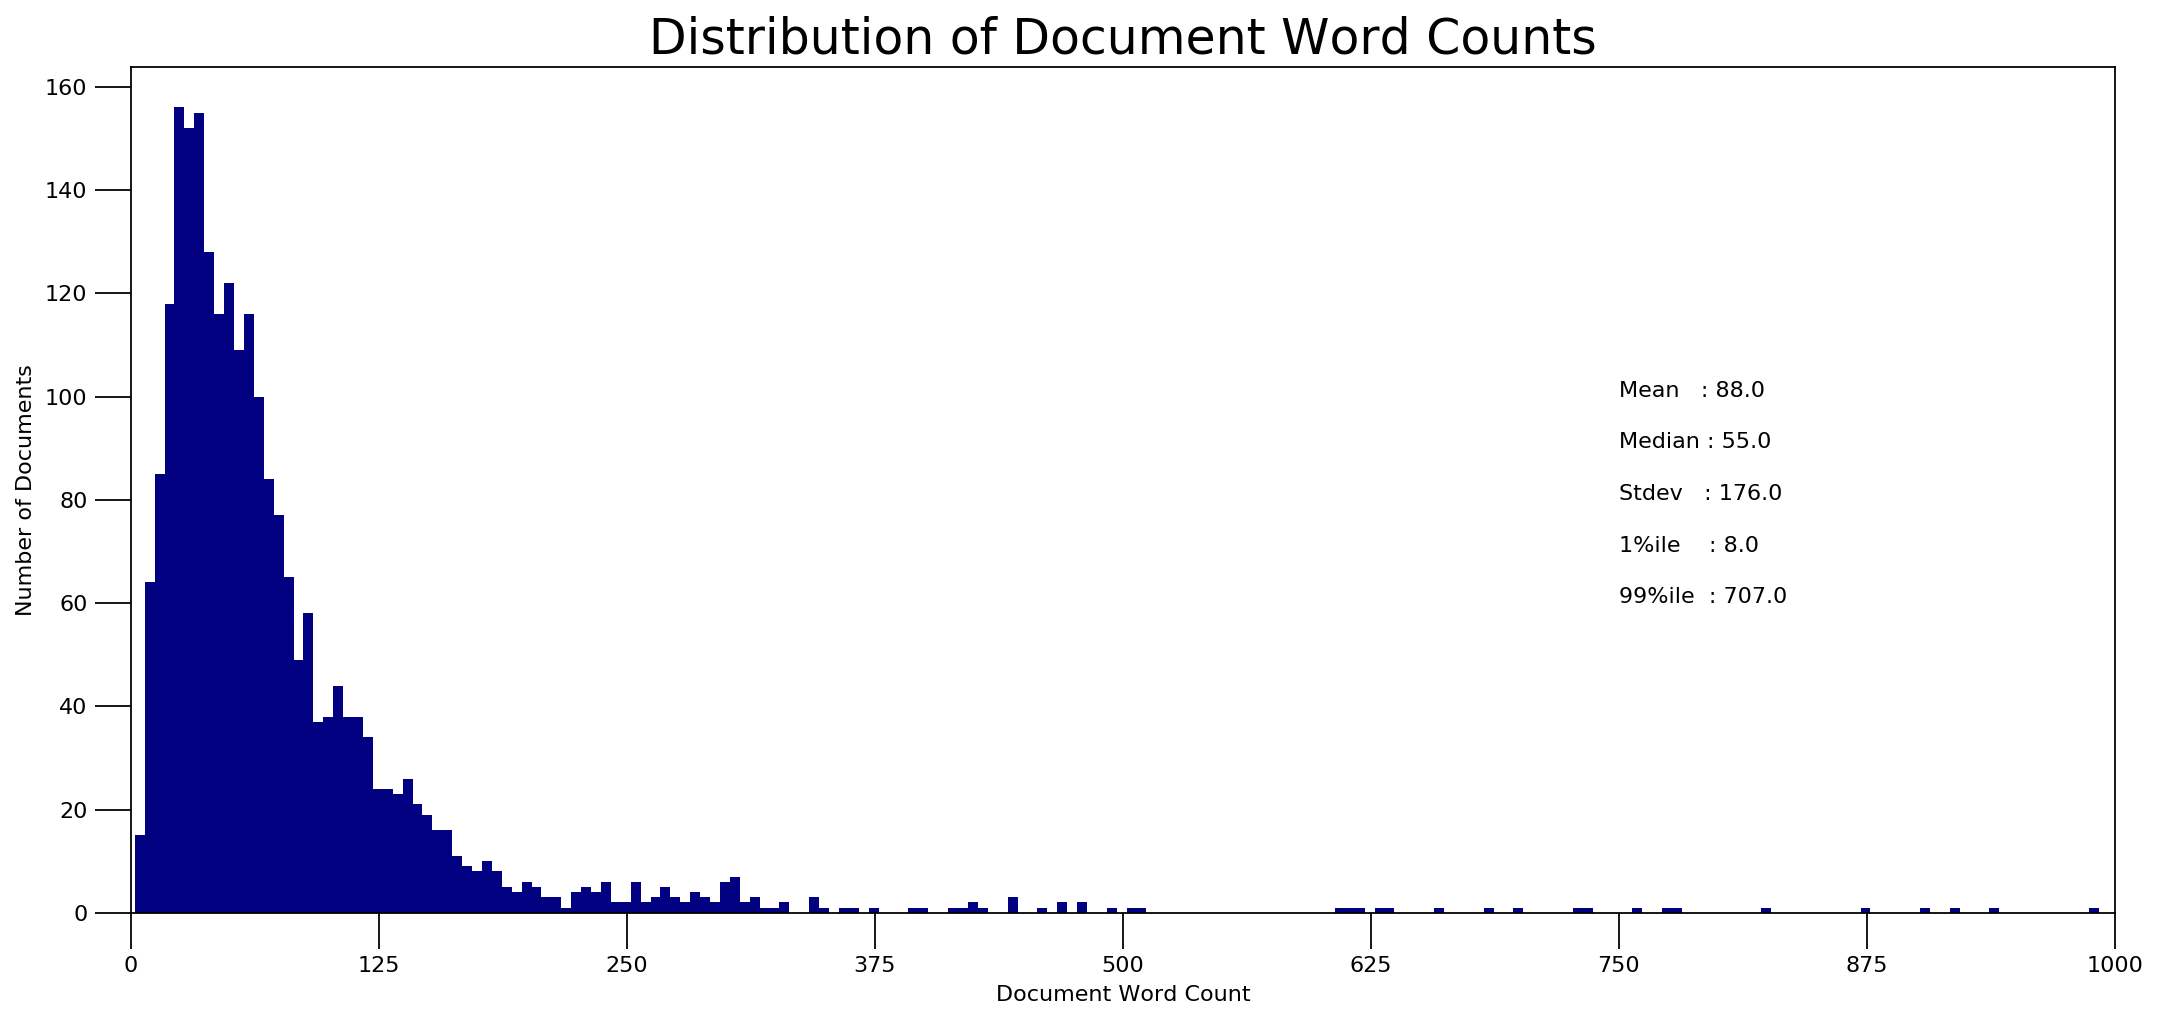

In [91]:
doc_lens = [len(d) for d in df_dominant_topic['Text']]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

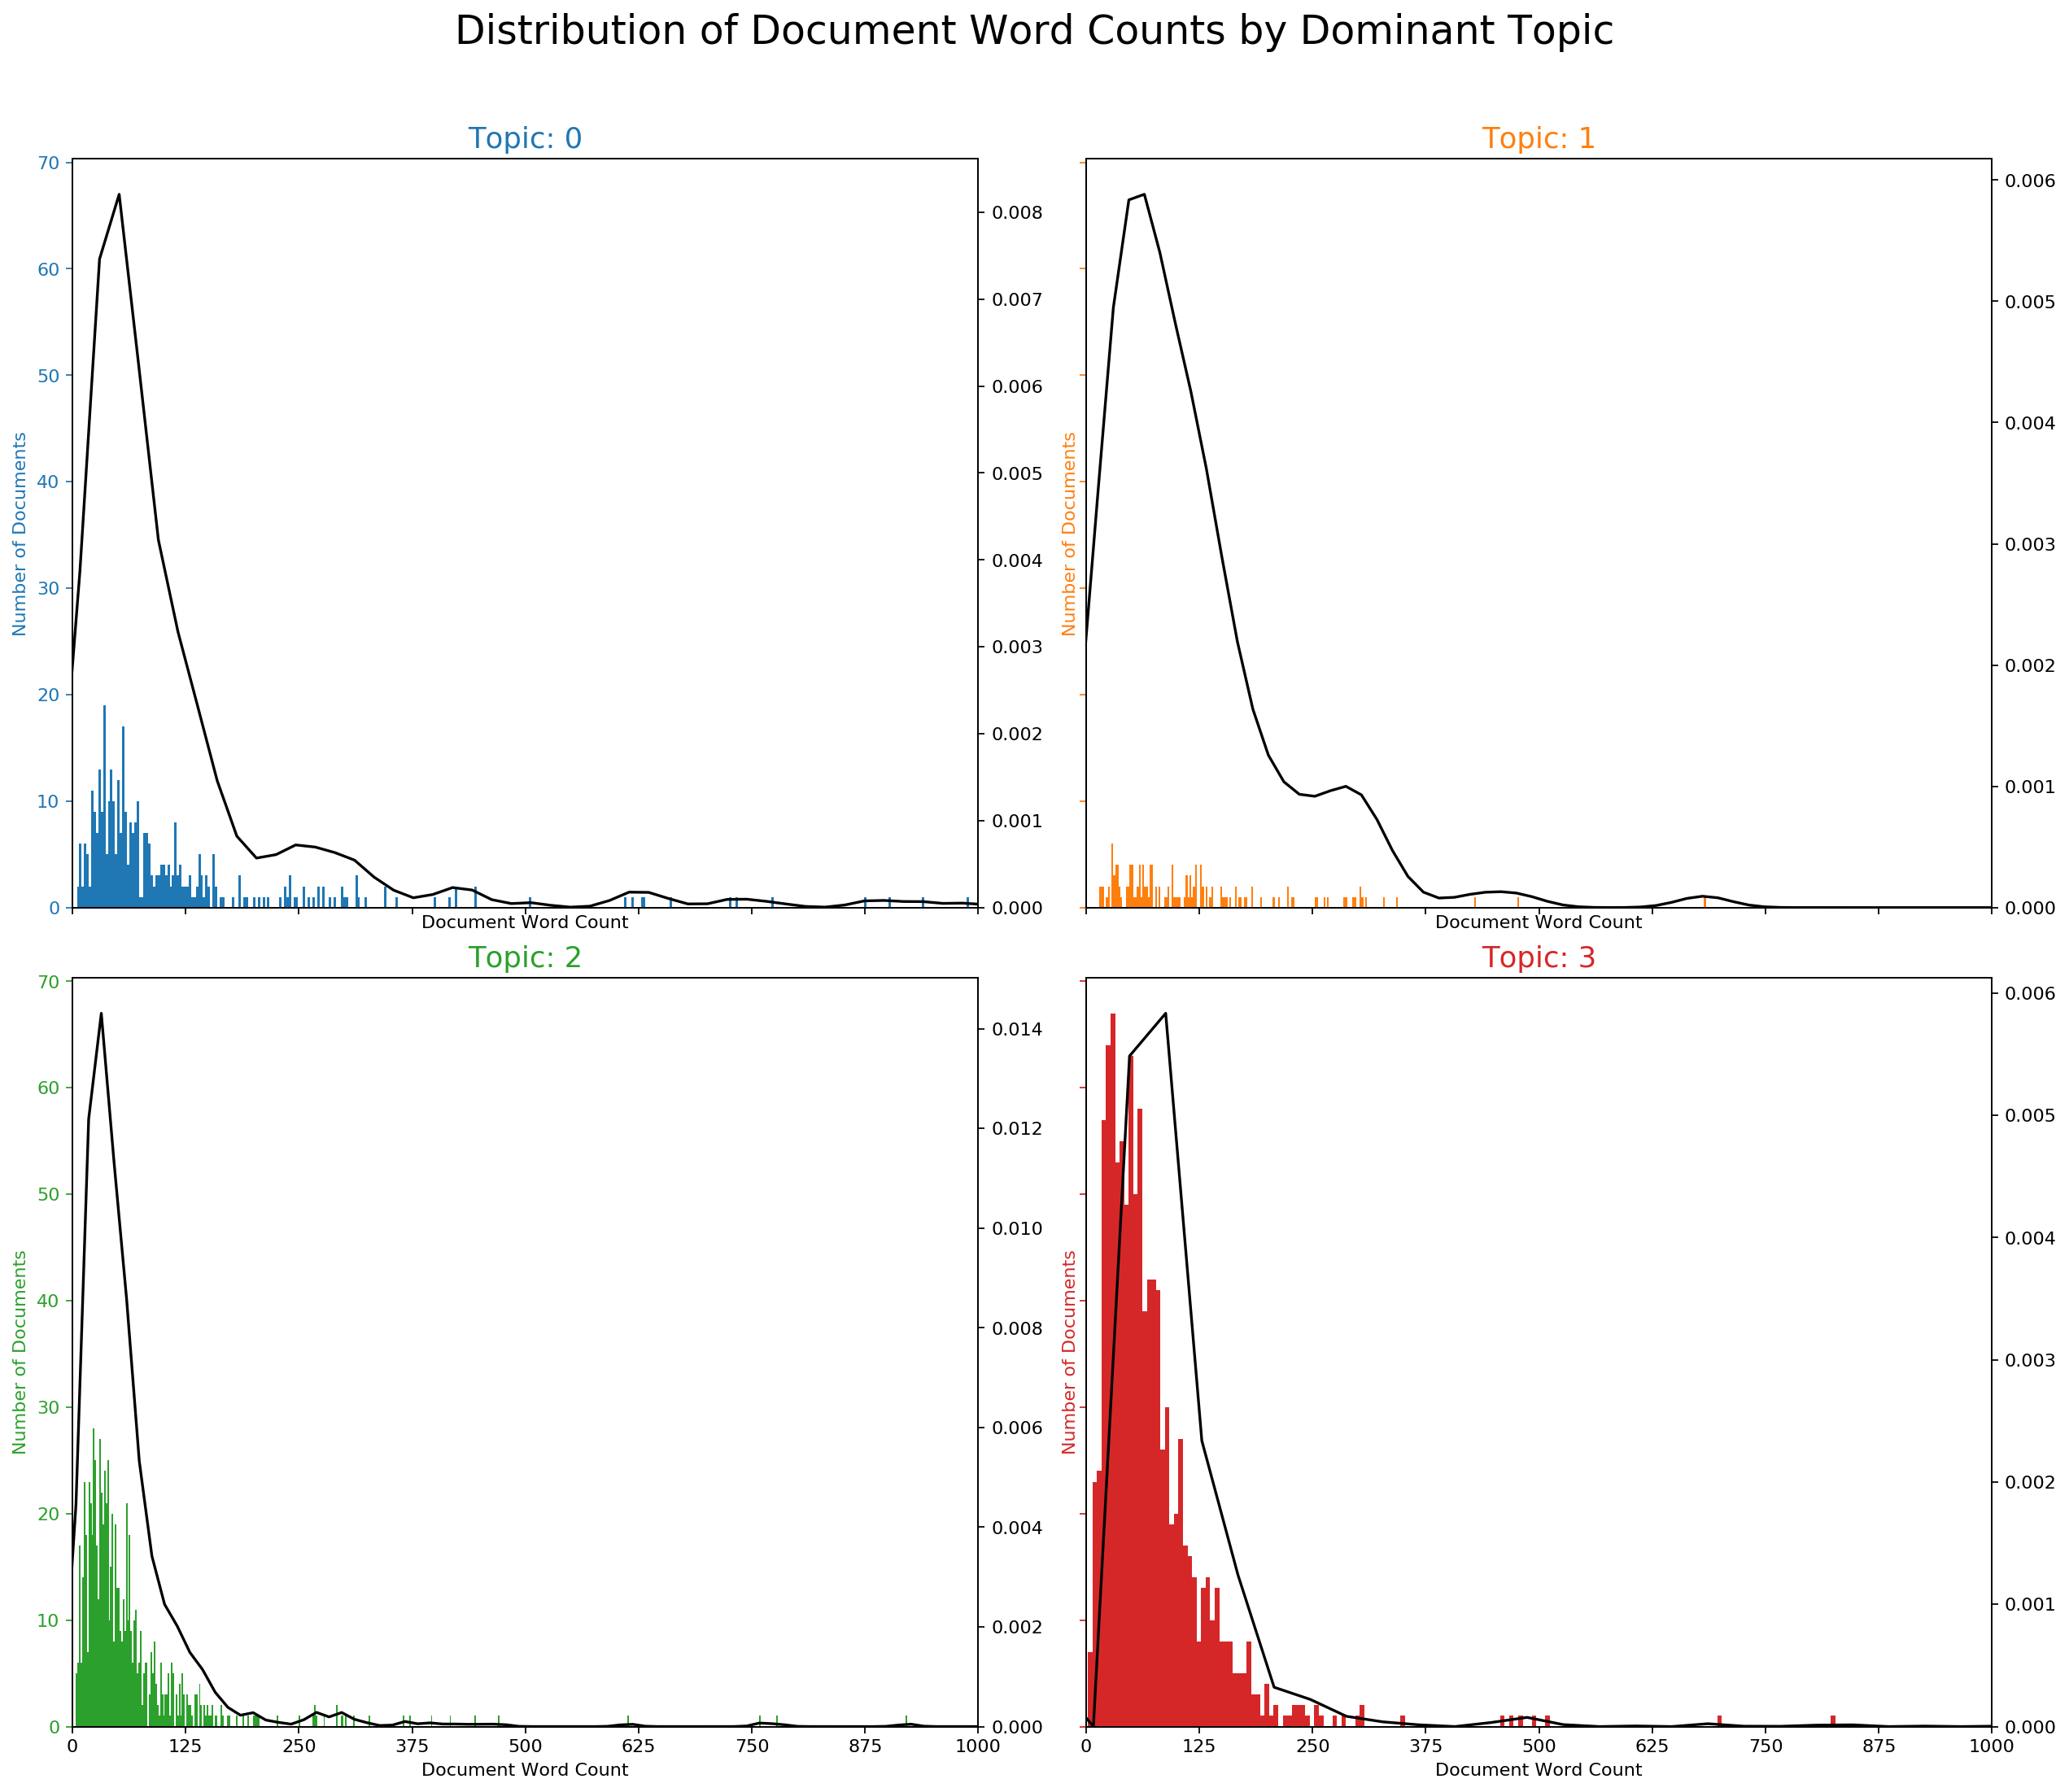

In [90]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

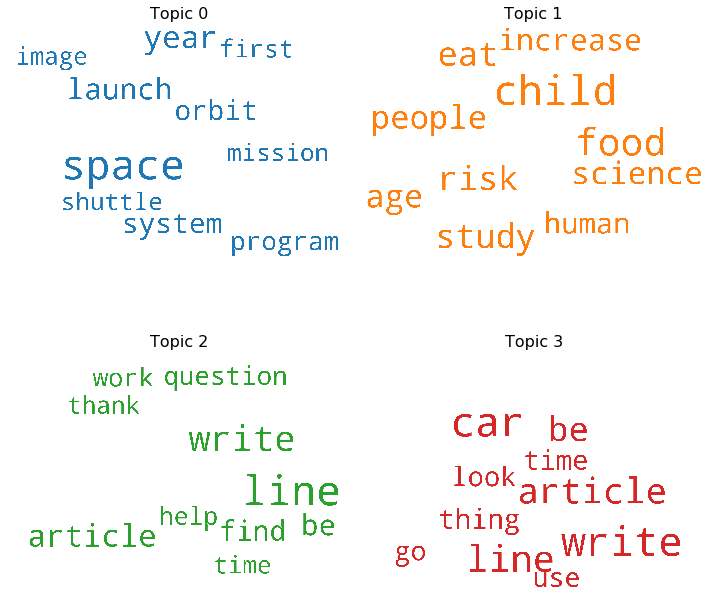

In [92]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [93]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.181514  0.054850       1        1  38.483856
2     -0.136480  0.032388       2        1  28.497744
0      0.091154 -0.251796       3        1  23.193169
1      0.226840  0.164559       4        1   9.825231, topic_info=       Term         Freq        Total Category  logprob  loglift
267   space   857.000000   857.000000  Default  30.0000  30.0000
5       car  1247.000000  1247.000000  Default  29.0000  29.0000
80    write  1917.000000  1917.000000  Default  28.0000  28.0000
17     line  2035.000000  2035.000000  Default  27.0000  27.0000
57   launch   389.000000   389.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
465  reason    64.636559   213.971924   Topic4  -5.7637   1.1232
439   never    67.290710   344.696259   Topic4  -5.7235   0.6866
20     make    69.320816   479.623291   Topic4  -5.6938   0.3860
917    fact    58.242470   215.590393   Topic4  -5.8679   1.0115
390    high    58.448868   521.991943   Topic4  -5.8644   0.1307

[265 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1543      2  0.990749    accept
300       1  0.995272  accident
302       1  0.839663  actually
302       2  0.151899  actually
302       4  0.008439  actually
...     ...       ...       ...
80        4  0.007300     write
38        1  0.283228      year
38        2  0.207467      year
38        3  0.507013      year
38        4  0.001166      year

[376 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

In [97]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

df.head(2)


,word,topic_id,importance,word_count
0,space,0,0.01762,862
1,year,0,0.00895,812


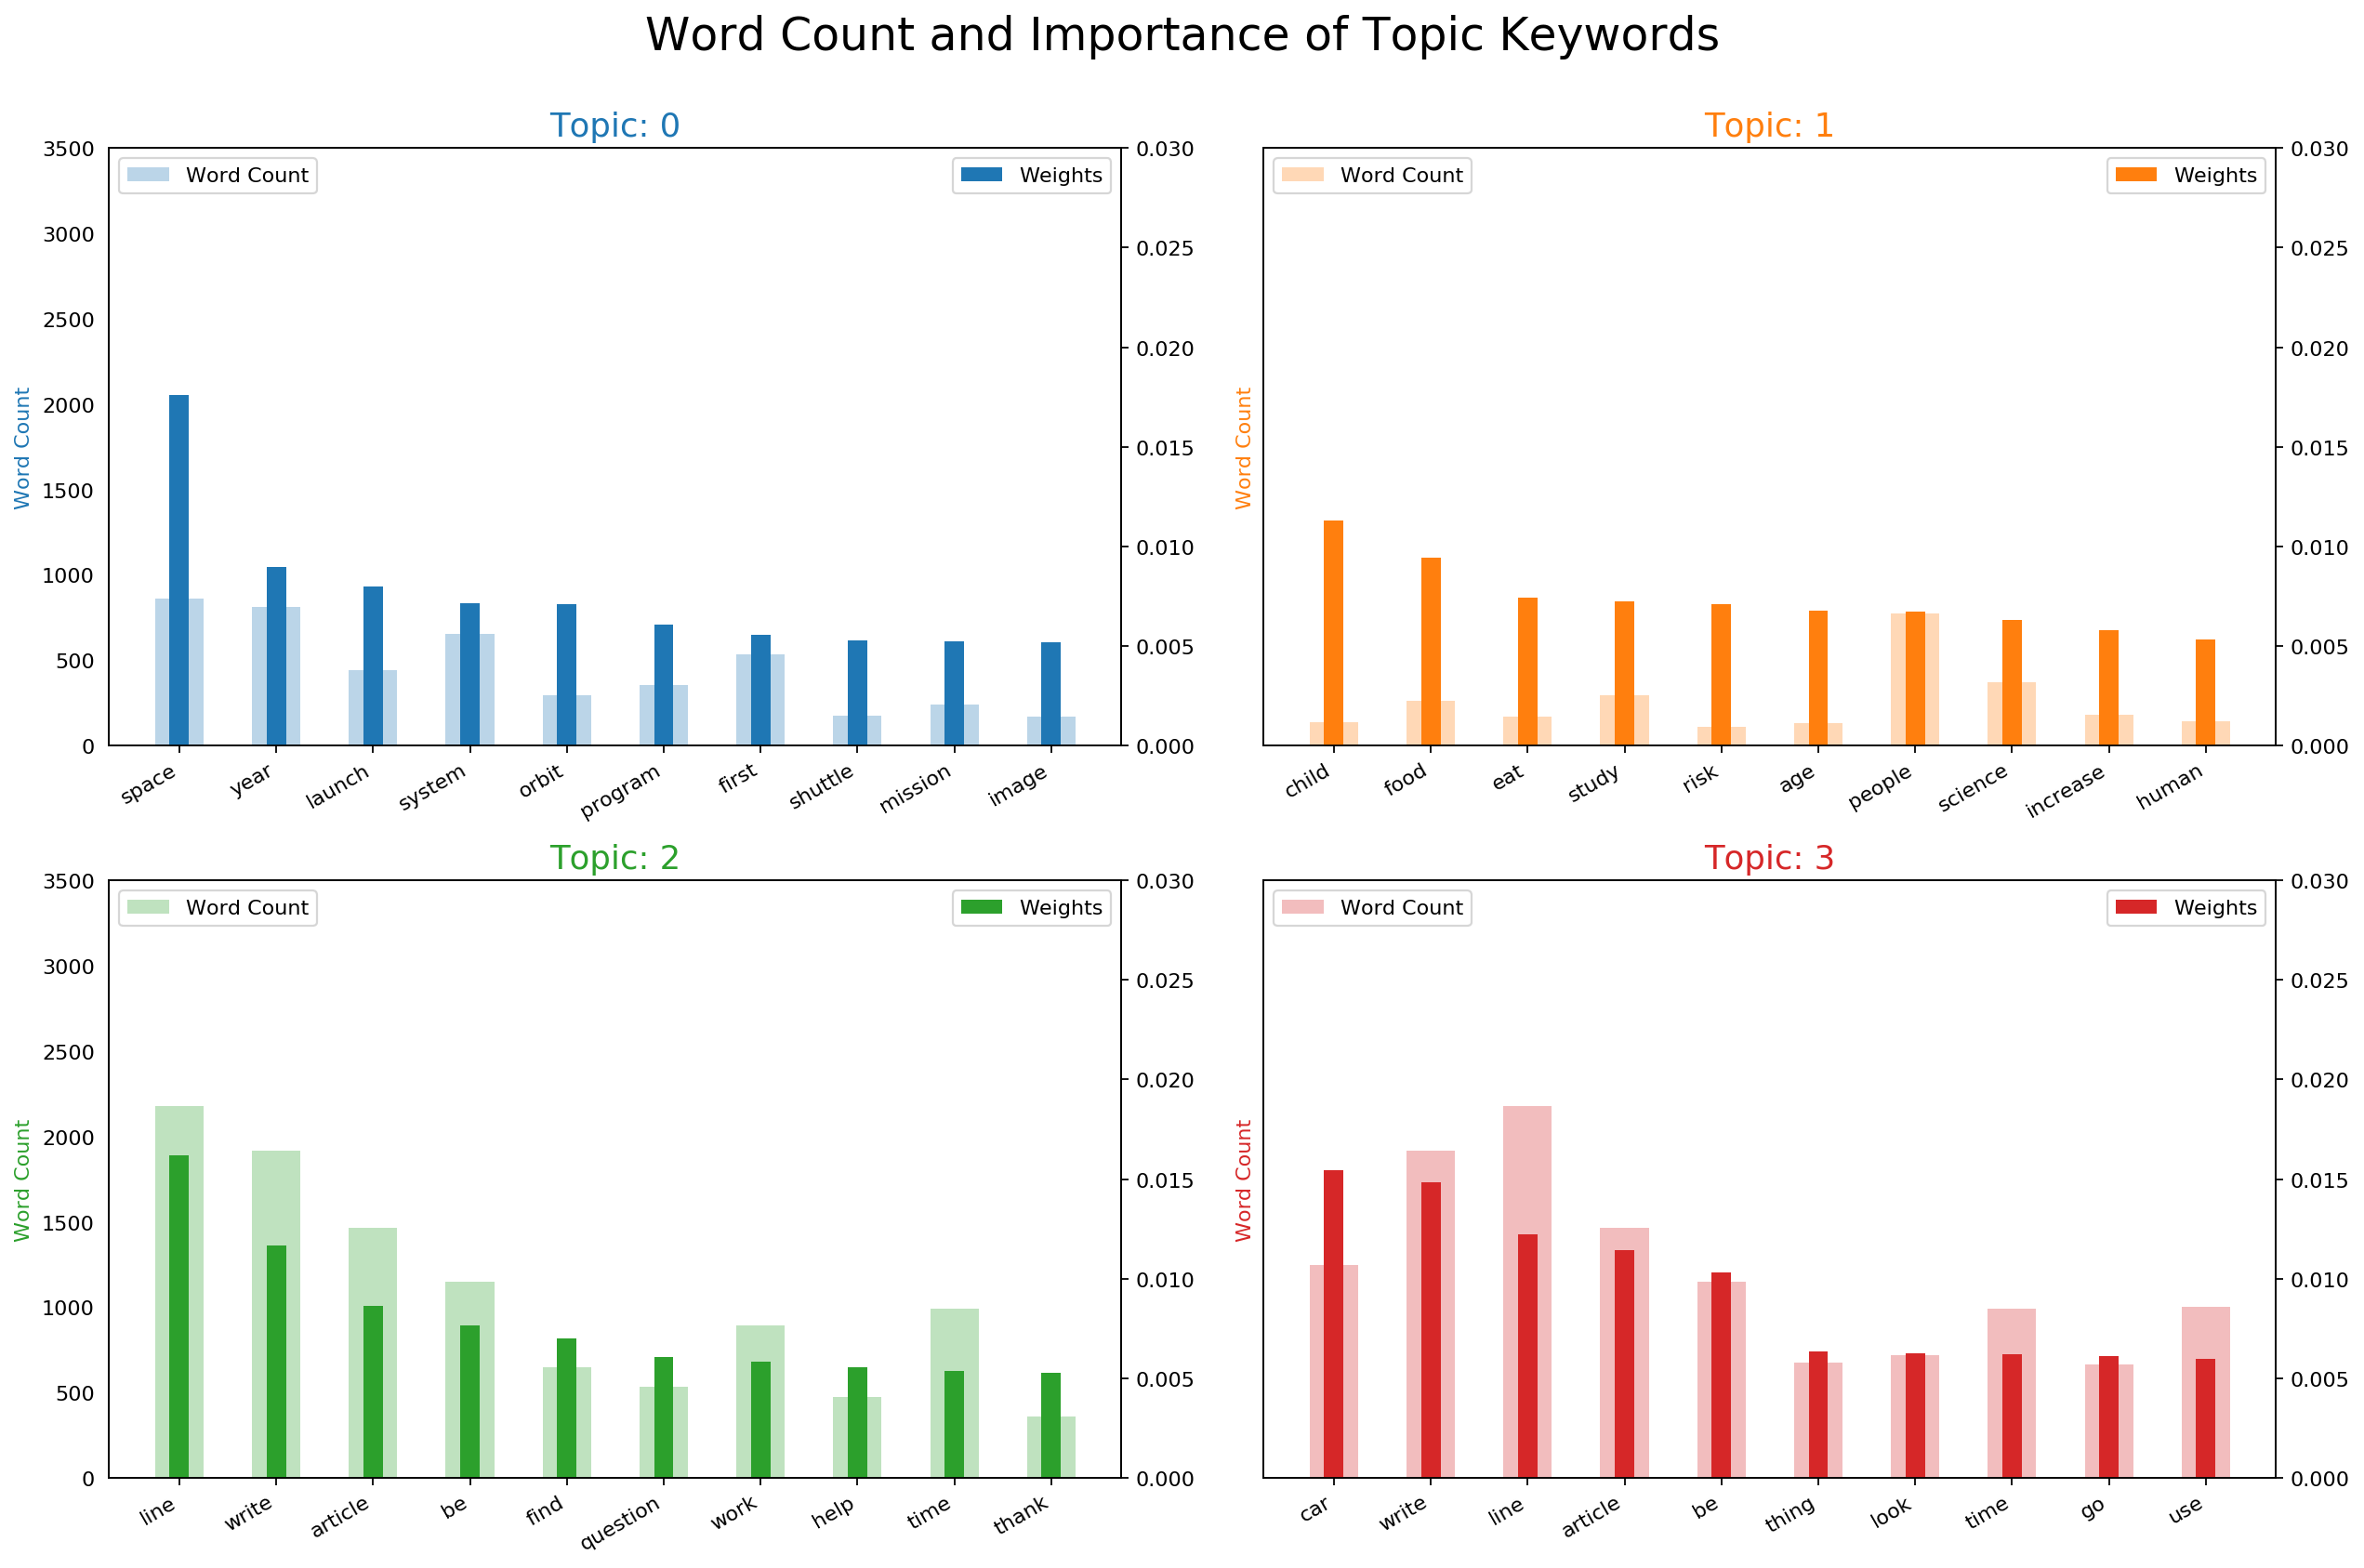

In [98]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [99]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [101]:
topic_weightage_by_doc 

,0,2,3,1
0,0.017377,0.398658,0.579324,NaN
1,0.284344,0.072302,0.639748,NaN
2,0.020193,0.648450,0.296212,0.035145
3,0.681931,0.108620,0.208843,NaN
4,0.080329,0.112937,0.783159,0.023575
...,...,...,...,...
2366,NaN,0.185884,0.807925,NaN
2367,0.532540,0.067312,0.323675,0.076473
2368,NaN,0.129173,0.859884,NaN
2369,0.109343,0.026507,0.819618,0.044532


In [102]:
dominant_topic_in_each_doc 

Dominant_Topic
0     385
1     149
2     787
3    1050
dtype: int64

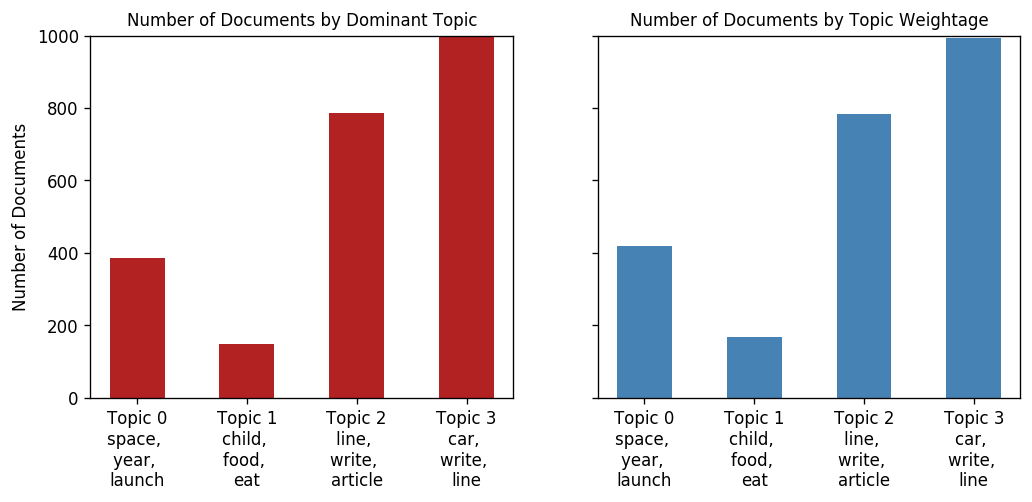

In [100]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()